# Imports

In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import ceil, sqrt
import sklearn
from sklearn.metrics import f1_score
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

# Some global variables

In [2]:
path = 'data/targets/'   #path to .ism files
batch_number = 0
#Get the list of filenames in data/targets/
#ordered by the size of class, descending:
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]
print(len(receptors))
receptors[:5]

73


[['DRD2.ism', '6229'],
 ['HTR1A.ism', '5592'],
 ['SLC6A4.ism', '5414'],
 ['OPRM1.ism', '5263'],
 ['ADORA1.ism', '4136']]

---

# Functions

## Preparing the dataset

In [3]:
def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    mol_matrix = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        mol_matrix.append(smile)
    return mol_matrix

#### Creating molecule representations

In [4]:
def get_class_vectors(mol_matrix, rType = 'fingerprint'):
    ''' For each molecule in the array (list of lists):
        create a binary vector showing which classes it belongs to
        and its representation for training (fingerprint or descriptor)
    '''
    cv_dict = {}
    for i,l in enumerate(mol_matrix):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else:
                    rep = list(fingerprint(mol)) + descriptor(mol)
                
                labels = [0]*len(mol_matrix)
                cv_dict[smile] = [rep, labels]
            cv_dict[smile][1][i] = 1
    return cv_dict

def fingerprint(mol):
    return GetMorganFingerprintAsBitVect(mol,2,1024)

def descriptor(mol):
    functions = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for function in functions:
        descriptors.append(function(mol))
    return descriptors

In [5]:
def prepare_sets(mol_matrix, val_prc=0.25, rType='fingerprint'):
    ''' Create training and validation sets with labels from an array of smiles, shuffling the data '''
    # mol_matrix = "list of lists of molecules"
    # mol_list = "list of molecules" <- how about class_i ?
    class_count = len(mol_matrix)
    lengths = [len(mol_list) for mol_list in mol_matrix]
    starts = [int(l*val_prc) for l in lengths] #start of training sets, end of validation sets
    
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,rType)
    
    # Create the validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols, val_labels = [],[]
    
    # shuffle molecules in each class so that selection for validation is random
    for mol_list in mol_matrix:
        random.shuffle(mol_list)
    
    for i in range(class_count):
        for j in range(starts[i]):
            mol = mol_matrix[i][j]
            val_mols.append(molecules[mol][0])
            val_labels.append(molecules[mol][1])
    # Conversion to numpy array for tensorflow training
    val_mols = np.array(val_mols)
    val_labels = np.array(val_labels)
    
    # Shuffle the remaining data and create the training set
    molecules_training = []
    for i,l in enumerate(mol_matrix):
        molecules_training += l[starts[i]:]
    
    random.shuffle(molecules_training)
    train_set = [[],[]]
    
    for mol in molecules_training:
        train_set[0].append(molecules[mol][0])
        train_set[1].append(molecules[mol][1])
    # Conversion to numpy array for tensorflow training
    train_set[0] = np.array(train_set[0])
    train_set[1] = np.array(train_set[1])
    
    return train_set, val_mols, val_labels

## Neuron layers

In [6]:
def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.relu(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=1024):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[i], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

In [7]:
def next_batch(data, size): #data = [[fingerprints], [labels]]
    ''' Extract the next batch from a dataset '''
    global batch_number
    batch_number = batch_number%((len(data[0]))//size)
    start = batch_number*size
    batch_number += 1
    return data[0][start:start+size], data[1][start:start+size]

def timer(start,end):
    ''' For timing the training of the network '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

In [8]:
def train_network(data, batch_size, epochs):
    ''' This function trains the network, returning the rate of training and validation accuracy '''
    # Variables:
    global start
    iterations = ceil(len(data[1]) * epochs / batch_size)
    print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    f1 = []
    batch_number = 0
    save_step=0
    # Training:
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        saver.save(session, "tmp/checkpoint", global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            fps, labels = next_batch(data, batch_size)
            session.run(train, feed_dict={x: fps, t: labels})
            
            # Show progress and make a checkpoint
            if i == 0 or (i+1)%(iterations//10) == 0:
                progress = int((i+1)/(iterations//10))*10
                now = timer(start,time.time())
                print("%3i" % progress + '%, ' + str(now))
                save_step += 1
                saver.save(session, "tmp/checkpoint", global_step = save_step)
            
            # Check predictions
            if i % 200 == 0:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: fps, t: labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                f1.append(f1_score(val_labels, val_predictions, average='micro'))
        # Final checkpoint
        saver.save(session, "tmp/checkpoint", global_step=save_step+1)
    return tr_rate, val_rate, f1

---

# Script

### Prepare data

In [9]:
num_class = 73 #first n most numerous classes - 2<=n<=73
mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

['CN1CCN(CC1)C2=Cc3ccccc3C(=C(C)C)c4ccccc24',
 'CN1CCN(CC1)C2=Nc3cc(Cl)ccc3Nc4ccccc24',
 'CN1CCC(CC1)C2=Cc3cc(Cl)ccc3Cc4ccccc24']

### Type of representation:

In [10]:
rType = 'fingerprint'

%time train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType)

CPU times: user 3min 53s, sys: 809 ms, total: 3min 54s
Wall time: 3min 54s


###  User-defined network variables:

In [11]:
layers = [200,200]
learning_rate = 0.001
batch_size = 50
epochs = 10

### Create and train the network

In [12]:
tf.reset_default_graph()
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
start = time.time()
# Automatic network variables
isize = len(val_mols[0])
osize = num_class

active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets

saver = tf.train.Saver(max_to_keep=12)

# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction
predict = tf.round(tf.nn.sigmoid(a))

# Train the network
tr_rate, val_rate, f1 = train_network(train_set, batch_size, epochs)
full_time = timer(start,time.time())
"--END--"

2017-05-24 12:32:52
19629  iterations
  0%, 00:00:01
 10%, 00:00:06
 20%, 00:00:12
 30%, 00:00:18
 40%, 00:00:24
 50%, 00:00:30
 60%, 00:00:36
 70%, 00:00:42
 80%, 00:00:47
 90%, 00:00:54
100%, 00:00:59


'--END--'

### Plot prediction accuracy

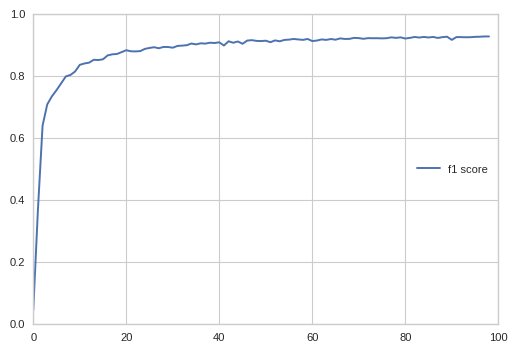

In [13]:
plt.plot(f1, label='f1 score')
plt.ylim([0,1])
plt.legend(loc=5);

Classes: 73, val_rate: 0.7801, Layers: [200, 200], rType: fingerprint
lr_rate: 0.001, batch_size: 50, epochs: 10, time: 00:01:00


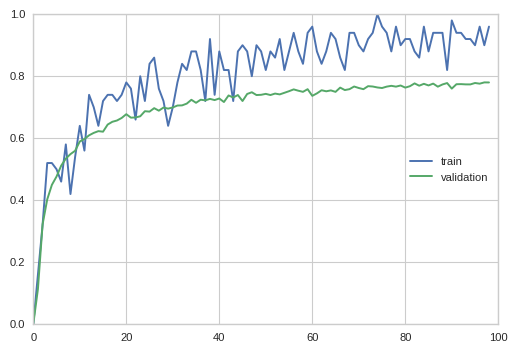

In [14]:
plt.plot(tr_rate, label='train')
plt.plot(val_rate, label='validation')
plt.ylim([0,1])
plt.legend(loc=5)
#print(max(val_rate), layers, learning_rate)
print("Classes: {:2}, val_rate: {:.4}, Layers: {}, rType: {}\nlr_rate: {}, batch_size: {}, epochs: {}, time: {}".format(
        osize, max(val_rate), layers, rType, learning_rate, batch_size, epochs, full_time))

---

# Analysis

### Analyze first layer weights

In [15]:
checkpoints = ['checkpoint-'+n for n in range(13)]

weights = []
with tf.Session() as sess:
    for ckpt in checkpoints:
        saver.restore(sess, 'tmp/'+ckpt)
        layer_1 = sess.run(active_layers['w'][0])
        weights.append(layer_1)

weights = np.array(weights)
w_first = weights[0] # first-layer weights before training (first checkpoint)
w_last = weights[-1] # first-layer weights after training (last checkpoint)
weights.shape

(12, 1024, 200)

In [16]:
# For each descriptor/fingerprint cell:
# sum of differences of weights between before and after training
# and sum of absolute values of these differences
for i in range(len(w_last)):
    print("{:2}:{:8.3}   {:.3}".format(
        i+1, sum(w_last[i]-w_first[i]), sum(np.absolute(w_last[i]-w_first[i]))
        ))

 1:    3.69   22.5
 2:    2.49   11.4
 3:    2.58   14.7
 4:   -1.25   13.6
 5:   0.519   12.5
 6:   0.419   17.4
 7:    2.62   20.4
 8:  -0.133   16.5
 9:    1.01   15.6
10:    1.42   17.9
11:    -1.2   13.0
12:   0.371   13.8
13:   0.888   14.6
14:     1.5   13.6
15:   0.311   13.4
16:  -0.264   10.9
17:   -4.42   20.2
18:    1.17   17.4
19:  -0.797   19.3
20:   -0.74   13.9
21:    4.88   18.8
22:   -4.31   16.9
23:    4.13   20.7
24:     2.2   20.8
25:   -5.15   17.5
26:  -0.887   16.1
27:  -0.698   13.5
28:   -1.66   17.1
29:   -3.63   19.4
30:  -0.183   13.6
31:    1.06   20.0
32:   0.456   16.0
33:   0.892   18.4
34:  -0.269   7.88
35:   -1.58   12.8
36:    3.71   20.6
37:   -1.84   12.7
38:    1.95   18.0
39:    2.29   21.5
40:  -0.318   14.6
41:  0.0243   17.6
42:   -1.47   16.4
43:   -3.41   13.2
44:   -3.72   18.6
45:    5.96   23.4
46:   -3.82   14.7
47:    1.97   14.7
48:   -3.62   18.8
49:     2.3   20.5
50:   -1.33   18.4
51:   -1.06   18.7
52:    1.89   17.0
53:   0.588 

In [17]:
c = 1  # descriptor / fingerprint cell to analyse further

In [18]:
print(np.where(w_last[c]-w_first[c] > 0.1))
print(np.where(w_last[c]-w_first[c] < -0.1))

(array([ 43,  44,  48,  51,  55,  62,  73,  75,  78,  80,  85,  90,  91,
       110, 131, 137, 158, 199]),)
(array([  2,   3,   9,  11,  32,  69,  97, 114, 122, 128, 132, 145, 148, 161]),)


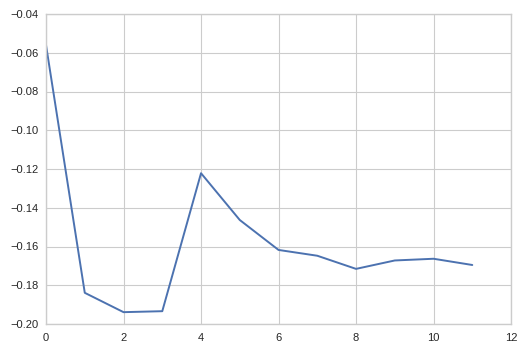

In [19]:
plt.plot(weights[:, c, 3]);

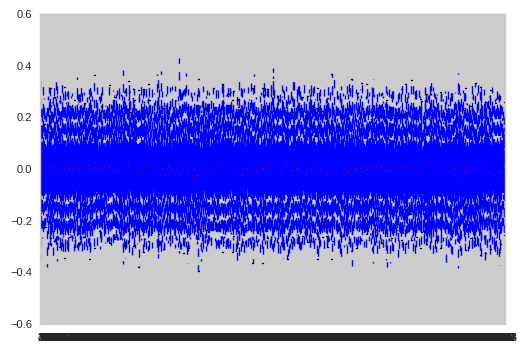

In [20]:
plt.boxplot(np.transpose(w_last-w_first));

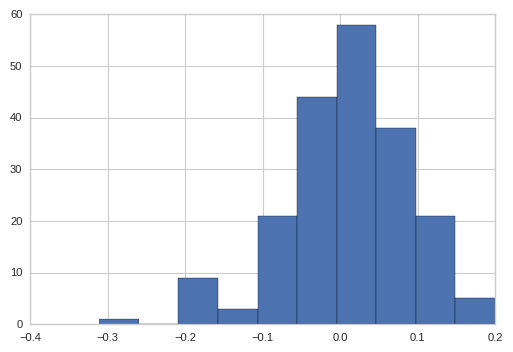

In [21]:
plt.hist(w_last[c]);

---